# **A Comprehensive Guide to Decision Tree Learning**

### From Basics to Practice: Classification and Regression

This notebook provides a deep dive into Decision Trees, one of the most fundamental and interpretable machine learning algorithms. We will cover the theory behind how they grow, how to use them for both categorization and continuous value prediction, how to visualize them, and crucially, how to prevent them from overfitting.

### Table of Contents
Introduction to Decision Trees

Part 1: Classification Trees

- The Intuition: Splitting Criteria (Gini Impurity & Entropy)

- Hands-on: The Iris Dataset

- Visualizing the Decision Boundaries

Part 2: Regression Trees

- The Intuition: Variance Reduction (MSE)

- Hands-on: California Housing Dataset

- Visualizing Regression Predictions

Part 3: Going Deeper - Overfitting and Pruning

- The Problem with Unconstrained Trees

- Key Hyperparameters for Pre-pruning

Part 4: Putting it All Together (Practical Workflow)

- Hyperparameter Tuning with GridSearchCV on Breast Cancer Data

Conclusion: Pros and Cons

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# Scikit-learn model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
# Scikit-learn visualization
from sklearn.tree import plot_tree
# Datasets
from sklearn.datasets import load_iris, fetch_california_housing, load_breast_cancer

# Setting plotting aesthetics
sns.set_theme(style="whitegrid")
%matplotlib inline

# **Introduction to Decision Trees**
A Decision Tree is a flowchart-like structure that makes predictions by asking a series of questions about the features in your data.

Think of it like a game of "20 Questions". To guess an animal, you might ask:

"Does it have 4 legs?" (Yes/No)

If Yes: "Does it bark?" (Yes -> Dog) / (No -> Cat)

If No: "Does it fly?" (Yes -> Bird) / (No -> Fish)

Key Terminology:

Root Node: The very top question (the starting point containing all data).

Internal Nodes: Questions asked in the middle of the structure.

Branches: The arrows connecting nodes, representing the answer (True/False, or < Value / >= Value).

Leaf Nodes (Terminal Nodes): The final endpoints where a prediction is made. No further questions are asked.

The goal of the algorithm is to find the best questions to ask at each step to separate the data most effectively.

# **Part 1: Classification Trees**
Classification trees are used when the target variable (Y) is categorical (e.g., "spam/not spam", "species A/B/C").

The Intuition: How does it choose the split?
The tree tries to split data into nodes that are as "pure" as possible. A node is 100% pure if it contains samples from only one class.

To measure purity, we use metrics like Gini Impurity or Entropy (Information Gain).

1. Gini Impurity (The default in sklearn)
Gini measures the probability of misclassifying a randomly chosen element from the set if it were randomly labeled according to the distribution of labels in the set.

A lower Gini score means higher purity.

Gini = 0: Perfect purity (all samples belong to one class).

Gini = 0.5: Maximum impurity (for a binary classification problem with a 50/50 split).

2. Entropy and Information Gain
Entropy comes from Information Theory. It measures the "chaos" or uncertainty in a node.

Entropy = 0: No uncertainty (perfect purity).

Entropy is high when classes are mixed evenly.

Information Gain is the difference between the entropy before a split and the weighted average entropy after the split. The algorithm chooses the split that maximizes Information Gain (i.e., reduces entropy the most).

Note: In practice, Gini and Entropy usually yield very similar trees. Gini is slightly faster to compute.





In [2]:
# 1. Load Data
iris = load_iris()
X_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
y_iris = iris.target

print("Feature Names:", iris.feature_names)
print("Target Classes:", iris.target_names)
display(X_iris.head())

Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Classes: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## Training the First Tree
We will instantiate a DecisionTreeClassifier. For now, we won't set any limits, allowing it to grow until it perfectly classifies the training data.

In [3]:
# Split data (even though we are just demonstrating fit, it's good practice)
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42
)

# Initialize the classifier (using 'gini' criterion by default)
tree_clf = DecisionTreeClassifier(random_state=42)

# Fit the model
tree_clf.fit(X_train_iris, y_train_iris)

print(f"Training Accuracy: {tree_clf.score(X_train_iris, y_train_iris):.4f}")
print(f"Test Accuracy: {tree_clf.score(X_test_iris, y_test_iris):.4f}")

Training Accuracy: 1.0000
Test Accuracy: 1.0000


## Visualizing the Tree
The ability to visualize the model is its strongest feature. We can trace exactly how it makes a decision.

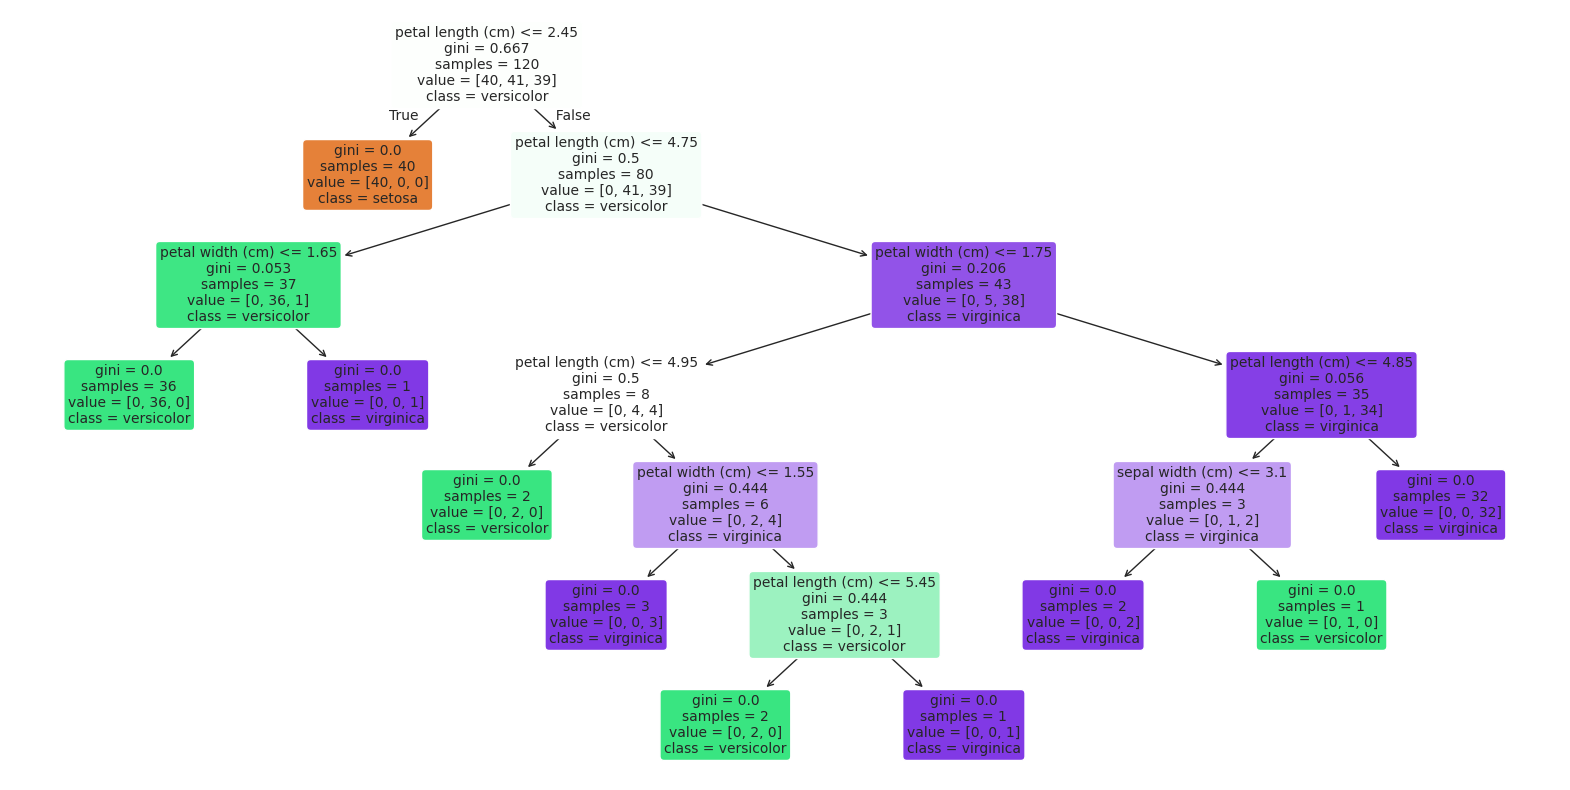

In [4]:
plt.figure(figsize=(20, 10))
plot_tree(
    tree_clf,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,       # Colors nodes by class majority
    rounded=True,      # Rounded corners for aesthetics
    fontsize=10
)
plt.show()

### How to read the plot:

1. Look at the root node: petal width (cm) <= 0.8.

2. Go left if True, right if False.

3. Look at the gini score in each node. Notice how it decreases as you go down the tree.

4. Look at samples: how many training instance reached this node.

5. value: The count of each class in that node [setosa, versicolor, virginica].

6. class: The majority class prediction at that node.

7. Notice the pure leaf node on the far left (Gini = 0.0). This indicates that petal width is a highly predictive feature for the 'setosa' species.

# **Part 2: Regression**

TreesRegression trees are used when the target variable is continuous (e.g., predicting house prices, temperature).

The Intuition: Variance ReductionIn classification, we used "majority voting" in the leaf node.In regression, the prediction of a leaf node is the average (mean) value of all training samples that land in that leaf.

How does it choose a split? It doesn't use Gini. Instead, it tries to minimize the Mean Squared Error (MSE) (or variance) in the resulting child nodes.The algorithm seeks the split feature ($j$) and split threshold ($t$) that minimizes the weighted sum of the MSE of the left child and the right child.

## Hands-on: Diabetes Dataset
We will predict the median house value in California districts.

In [5]:
# 1. Load Data

from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X_cali = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y_cali = diabetes.target # Target is a quantitative measure of disease progression

print("Features:", diabetes.feature_names)
display(X_cali.head())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_cali, y_cali, test_size=0.2, random_state=42
)

Features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


## Training the Regression Tree
We use DecisionTreeRegressor.

Important: Regression trees on complex datasets can grow massive and overfit terribly. To visualize it, we will intentionally limit the depth using max_depth=3.

In [6]:
# Initialize Regressor with a depth limit for visualization purposes
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42)

# Fit model
tree_reg.fit(X_train, y_train)

# Evaluate
y_pred= tree_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse:.4f}")

Test Mean Squared Error: 3552.7013


## Visualizing the Regression Tree

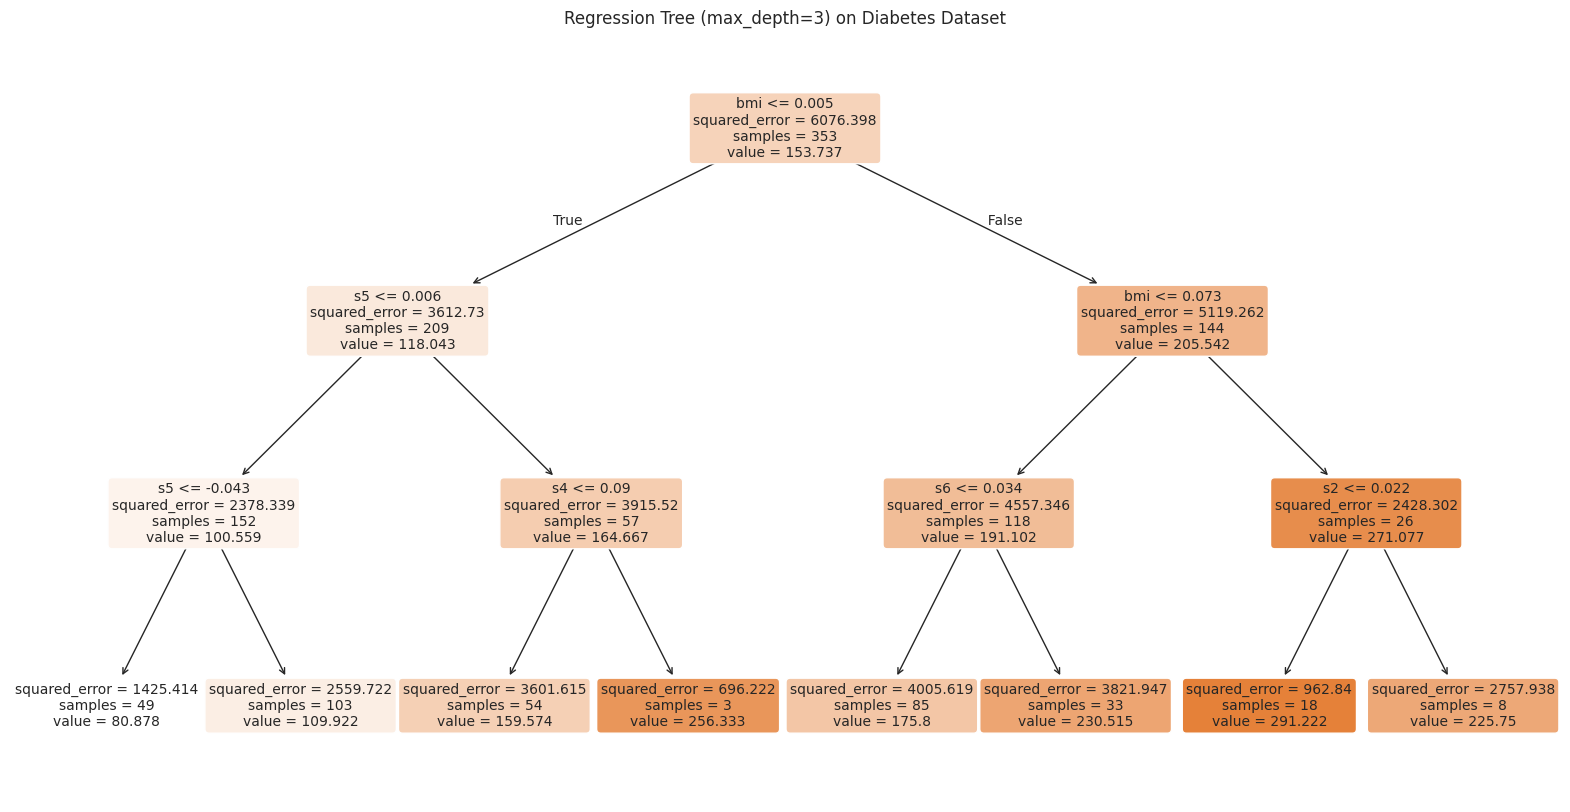

In [7]:
plt.figure(figsize=(20, 10))
plot_tree(
    tree_reg,
    feature_names=diabetes.feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Regression Tree (max_depth=3) on Diabetes Dataset")
plt.show()

### How to read regression tree plots: It looks similar to classification, but:

Notice the root node.


Let's break down how to interpret the regression tree plot for the Diabetes dataset, especially given its max_depth=3:

Split Conditions (e.g., s5 <= 0.0076): At each internal node, the tree asks a question about a feature. For example, the root node might split on s5 <= 0.0076. If a sample's s5 value is less than or equal to 0.0076, it goes to the left child; otherwise, it goes to the right child. The tree algorithm chooses these splits to best separate the data based on the target variable (disease progression).

mse (Mean Squared Error): This value indicates the error for the samples within that particular node. The goal of the tree is to minimize MSE. As you move down the tree from the root to the leaf nodes, you'll generally observe the mse values decreasing. A mse of 0 would mean all samples in that node have the exact same target value (perfect prediction for those samples).

samples: This number tells you how many training instances from your dataset reached that specific node. It helps you understand the distribution of data points across the tree's branches.

value: For regression trees, the value in a node is the predicted output for all samples that fall into that node. Specifically, it's the average (mean) of the target variable (disease progression) for all the training samples that reached that node. When a sample reaches a leaf node, this value is its final prediction.

Path to Prediction: To predict for a new data point, you start at the root node and follow the branches based on the feature conditions until you reach a leaf node. The value in that leaf node is the prediction for your new data point.

## Visualizing Regression Decision Boundaries (The "Stair-step" Nature)
Decision trees don't create smooth curves. They create "stair-steps". To visualize this, let's train a tree on just ONE feature.

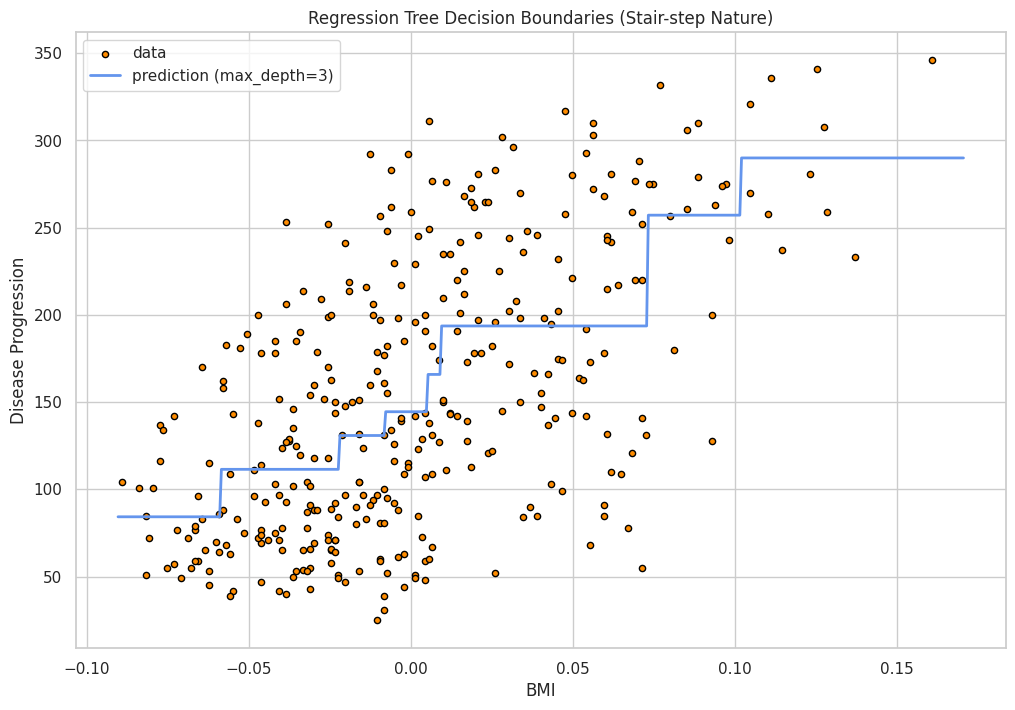

In [8]:
# Select a single feature for visualization (e.g., 'bmi')
X_single_feature = X_cali[['bmi']]
y_single_feature = y_cali

# Split data (optional for this specific visualization, but good practice)
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(
    X_single_feature, y_single_feature, test_size=0.2, random_state=42
)

# Train a DecisionTreeRegressor on the single feature
tree_reg_single = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg_single.fit(X_train_single, y_train_single)

# Generate a range of values for the feature to plot the decision boundary
X_plot = pd.DataFrame(np.linspace(X_single_feature.min(), X_single_feature.max(), 500), columns=['bmi'])
y_plot = tree_reg_single.predict(X_plot)

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(X_train_single, y_train_single, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_plot, y_plot, color="cornflowerblue", linewidth=2, label="prediction (max_depth=3)")
plt.xlabel("BMI")
plt.ylabel("Disease Progression")
plt.title("Regression Tree Decision Boundaries (Stair-step Nature)")
plt.legend()
plt.grid(True)
plt.show()

The plot you see visualizes the 'stair-step' nature of a regression tree when trained on a single feature, in this case, 'BMI' from the Diabetes dataset:

Orange Scatter Points: These represent our actual training data points. The x-axis is the 'BMI' feature, and the y-axis is the target variable (disease progression).

Blue Line: This line shows the predictions made by our DecisionTreeRegressor (with max_depth=3) across a continuous range of 'BMI' values. We'll notice that the line is not smooth; instead, it's composed of horizontal segments connected by vertical drops or rises. These segments are the 'steps'.

What it means: Each horizontal segment corresponds to a leaf node in the decision tree. For any BMI value falling within the range of that segment, the tree predicts a constant value (the average of the target values of the training samples that ended up in that leaf node). The vertical changes occur at the split points chosen by the tree, where the prediction transitions from one constant value to another. This clearly illustrates that decision trees make piecewise constant predictions, creating these characteristic 'stair-step' boundaries rather than smooth curves.

# **Part 3: Going Deeper - Overfitting and Pruning**

The Main Problem: Overfitting
Decision trees are "greedy". They make the best immediate split at every step without considering future consequences.

If left unchecked (like our first Iris example), a tree will keep splitting until every single training leaf is pure. It will memorize the training data perfectly (100% training accuracy) but will fail to generalize to new data. It has high variance.

### The Solution: Pruning
Pruning is the technique of reducing the size of the tree to prevent overfitting. There are two main types:

### Pre-pruning (Early Stopping): Stopping the tree before it finishes growing by setting constraints. This is the standard approach in scikit-learn.

### Post-pruning (Cost-Complexity Pruning): Growing the full tree and then cutting back branches that don't provide much power. (Scikit-learn supports this via ccp_alpha, but it's more advanced).

### Key Pre-pruning Hyperparameters
These are the knobs you turn to control tree growth in DecisionTreeClassifier and DecisionTreeRegressor.

**max_depth**:

- The maximum depth of the tree.

- Low value (e.g., 3): Reduces variance, increases bias (underfitting risk).

- None (default): Grows until pure. High variance (overfitting risk).

**min_samples_split**:

- The minimum number of samples required to split an internal node.

- Higher value (e.g., 20): Prevents the tree from creating very specific branches based on just a few data points.

**min_samples_leaf**:

- The minimum number of samples required to be at a leaf node.

- Very Important. This guarantees that a prediction is based on at least N samples, smoothing the decision boundary.

**max_features**:

- The number of features to consider when looking for the best split at each node. Reducing this adds randomness and can help reduce overfitting (this is the core concept behind Random Forests).

# **Part 4: Putting it All Together (Practical Workflow)**

**Dataset Loading**

We will use the Breast Cancer dataset (binary classification) and use GridSearchCV to find the best combination of hyperparameters to optimize bias vs. variance.

In [9]:
# 1. Load Data
data_bc = load_breast_cancer()
X_bc = pd.DataFrame(data_bc.data, columns=data_bc.feature_names)
y_bc = data_bc.target

# 2. Split Data (Crucial step!)
X_train, X_test, y_train, y_test = train_test_split(
    X_bc, y_bc, test_size=0.25, random_state=42, stratify=y_bc
)
# Note: 'stratify=y_bc' ensures training and test sets have the same proportion of class labels.

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 426
Testing samples: 143


**Hyperparameter Tuning with GridSearchCV**

We don't know ahead of time if a depth of 5 or 10 is better, or if we need 5 samples in a leaf or 20. We try combinations systematically.

In [10]:
# Define the base model
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search
# We are trying combinations of depth and leaf sample size.
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Instantiate GridSearchCV
# cv=5 means 5-fold cross-validation used to evaluate each parameter combination internally.
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, # Use all processors
    verbose=1
)

# Fit the search process
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 5, 10, 20]},
             scoring='accuracy', verbose=1)

**Evaluating the Best Model**

Let's see which parameters won and how well they perform on the unseen test set.

In [11]:
print("Best Hyperparameters found:", grid_search.best_params_)
print(f"Best Cross-validation Accuracy: {grid_search.best_score_:.4f}")

# Retrieve the best model
best_tree = grid_search.best_estimator_

# Final evaluation on Test data
y_pred_final = best_tree.predict(X_test)

print("\n--- Final Test Set Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_final, target_names=data_bc.target_names))

Best Hyperparameters found: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1}
Best Cross-validation Accuracy: 0.9578

--- Final Test Set Evaluation ---
Accuracy: 0.9301

Classification Report:

              precision    recall  f1-score   support

   malignant       0.88      0.94      0.91        53
      benign       0.97      0.92      0.94        90

    accuracy                           0.93       143
   macro avg       0.92      0.93      0.93       143
weighted avg       0.93      0.93      0.93       143



We likely found that a restricted tree (e.g., max_depth=5 or min_samples_leaf=5) performed better in cross-validation than the default fully grown tree, because it generalizes better.

# **Conclusion**

### Advantages of Decision Trees

1. Interpretability: Very easy to understand and visualize. Non-experts can understand the logic.

2. No Data Scaling: Requires little data preparation. You don't need to scale or normalize features.

3. Handles Mixed Data: Can handle both numerical and categorical features (though sklearn's current implementation requires encoding categorical features numerically first).

4. Feature Importance: Implicitly performs feature selection; top nodes are the most important features.

### Disadvantages of Decision Trees

1. Overfitting: Highly prone to creating overly complex trees that don't generalize well (high variance).

2. Instability: Small variations in the data can result in a completely different tree being generated. This is because they are hierarchical; an early change affects everything below it.

3. Not Smooth: As seen in regression, they cannot make smooth continuous predictions, only step-functions.


### The Bias-Variance Tradeoff

 It is the central problem in supervised machine learning. It describes the conflict when trying to minimize your total error: you want your model to capture the underlying patterns in the data (low bias) without capturing the noise (low variance).

Here is the breakdown:

1. Bias (Underfitting)

- Definition: Error introduced by approximating a real-world problem, which may be complex, by a too-simple model.

- What it means: The model pays very little attention to the training data and oversimplifies the model.

- Result: High bias causes Underfitting. The model effectively "misses the point" and has high error on both training and test data.
+1

- Example: Using a linear regression (a straight line) to model data that is clearly curved.

2. Variance (Overfitting)

- Definition: Error introduced by the model's sensitivity to small fluctuations (noise) in the training set.

- What it means: The model pays too much attention to the specific training data, memorizing random noise rather than the intended outputs.

- Result: High variance causes Overfitting. The model performs perfectly on training data but fails on new, unseen data (test data).
+1

- Example: A Decision Tree with no depth limit that creates a unique leaf node for every single training point.

3. The Tradeoff

- We cannot easily minimize both simultaneously; there is a tension between them.

- Low Complexity (Simple Models): High Bias, Low Variance. (Stable, but inaccurate).

- High Complexity (Complex Models): Low Bias, High Variance. (Accurate on training, but unstable/noisy).

- The Goal: Find the "Sweet Spot" in the middle where the Total Error (Bias + Variance) is minimized.

### The "Bullseye" Analogy

Imagine a target board:

- High Bias, Low Variance: Your shots are consistently clustered together (low variance) but they are all far away from the bullseye (high bias).

- Low Bias, High Variance: Your shots are centered around the bullseye (low bias), but they are scattered wildly all over the place (high variance).

- Perfect Model: Shots are tightly clustered right in the center (Low Bias, Low Variance).

### In the Context of Decision Trees

- Shallow Tree (e.g., depth 1): High Bias. It treats everything too broadly.

- Deep Tree (e.g., depth 50): High Variance. It captures noise.

- Pruned Tree (e.g., depth 5): The Tradeoff. It balances capturing the pattern without memorizing the noise.